In [1]:
import random
import itertools
import sys, os, glob
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

this_folder = '/'.join(os.getcwd().split('/')[:])
tichu_folder = this_folder+'/Tichu-gym/'

for p in [this_folder, tichu_folder]:  # Adds the parent folder (ie. game) to the python path
    if p not in sys.path:
        sys.path.append(p)

# Played cards -> remaining cards

In [2]:
from scraper.tichumania_game_scraper import TichumaniaScraper, PlayedCards


In [3]:
def load_playedcards():
    scraper = TichumaniaScraper()
    # load from all files
    playedcards = []
    os.chdir("/mnt/Data/Dropbox/Studium/EPFL/MA4/sem_project/Tichu-gym/scraper/tichumania_scraper_out/")
    for file in glob.glob("*played_cards*.json"):
        print(file)
        playedcards.extend([PlayedCards.from_dict(d) for d in scraper._load_from_file(file)])
    return [pc.to_real_cards() for pc in playedcards]

In [4]:
scraper = TichumaniaScraper()
# merge all played_cards files into the file 'played_cards.json'
realpcs = load_playedcards()
print(realpcs[:2])

file '/mnt/Data/Dropbox/Studium/EPFL/MA4/sem_project/Tichu-gym/scraper/tichumania_scraper_out/.gamenumbers.json' did not exist, returning default: set()
file '/mnt/Data/Dropbox/Studium/EPFL/MA4/sem_project/Tichu-gym/scraper/tichumania_scraper_out/.gameoverviews.json' did not exist, returning default: set()
nbr scraped_gamenumbers:  0
nbr scraped_gameoverviews:  0
file '/mnt/Data/Dropbox/Studium/EPFL/MA4/sem_project/Tichu-gym/scraper/tichumania_scraper_out/.gamenumbers.json' did not exist, returning default: set()
file '/mnt/Data/Dropbox/Studium/EPFL/MA4/sem_project/Tichu-gym/scraper/tichumania_scraper_out/.gameoverviews.json' did not exist, returning default: set()
nbr scraped_gamenumbers:  0
nbr scraped_gameoverviews:  0
[]


In [ ]:
len(realpcs)

In [ ]:
# make data for handcards of len 2
from gym_tichu.envs.internals import CardSet, CardRank
def cards_to_binary_list(cards):
    rank_dict = CardSet(cards).rank_dict()
    return [len(rank_dict.get(rank, [])) for rank in CardRank]

data = []
for pc in realpcs:
    for played, handcards in pc.iter_plays():
        if len(handcards) == 2:
            data.append((cards_to_binary_list(played), cards_to_binary_list(handcards)))
random.shuffle(data)
X_data = np.array([np.array(tup[0], dtype=np.int64) for tup in data])
Y_data =  np.array([np.array(tup[1], dtype=np.int64) for tup in data])



len_testdata = int(len(X_data)*0.8)

X_train, Y_train = X_data[:len_testdata], Y_data[:len_testdata]
X_test, Y_test = X_data[len_testdata:], Y_data[len_testdata:]


In [ ]:
X_train.shape

In [ ]:
Y_train.shape

In [ ]:
X_test.shape

In [ ]:
Y_test.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
import tensorflow as tf

def true_mse(y_true, y_pred):
    z = K.clip(y_true, 0, 1) * y_pred
    return (y_true - z)**2    
    

model = Sequential([
    Dense(56, input_dim=17, activation='elu'),
    Dense(56, activation='elu'),
    Dense(32, activation='linear'),
    Dense(17, activation='linear'),
])
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'accuracy', true_mse])


In [ ]:
model.summary()

In [ ]:
# Train
start_t = time()
history = model.fit(X_train, Y_train,
          batch_size=2**15, epochs=10000, verbose=0,
          validation_data=(X_test, Y_test))
end_t = time()
end_t - start_t

In [ ]:
os.getcwd()

In [ ]:
filename = "/mnt/Data/Dropbox/Studium/EPFL/MA4/sem_project/nn_training/model_{}.h5f".format(time())
with open(filename, 'w'):
    pass # create the file
model.save_weights(filename)

In [ ]:
# visualize history

keys = history.history.keys()
print(keys)
for key, val_key in [('loss', 'val_loss'), ('mean_squared_error', 'val_mean_squared_error'), ('acc', 'val_acc'),
                    ('true_mse', 'val_true_mse')]:
    plt.plot(history.history[key])
    plt.plot(history.history[val_key])
    plt.title(str(key))
    plt.ylabel(str(key))
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
X_test[:1].shape

In [ ]:
# try one example
nbr_predictions = 100
inpts = X_test[:nbr_predictions]
reals = Y_test[:nbr_predictions]
predictions = model.predict(inpts, verbose=2)

In [ ]:
k = 2
for idx in range(len(predictions)):
    pred = predictions[idx]
    real = reals[idx]
    print("real idx: ", pred.argsort()[-k:][::-1])
    real_idxs = []
    for i, v in enumerate(real):
        real_idxs.extend([i]*v)
    print("real idx: ", real_idxs)
    print("pred: ", pred)
    print("real: ", real)
    print("==================")

    

# Determine average nbr possible combination

In [1]:
from gym_tichu.envs.internals import Deck, CardSet

In [48]:
def rand_cards(len_=14):
    deck = Deck(full=True)
    pile, _, _, _ = deck.split(random_=True)
    ret = CardSet(pile[:len_])
    return ret

In [60]:
def nbr_possible_combinations(len_=14, nbr_datapoints=10000):
    nbrs = [len(list(rand_cards(len_=len_).possible_combinations())) for _ in range(nbr_datapoints)]
    print("mean: ", np.median(nbrs))
    print("min: ", min(nbrs))
    print("max: ", max(nbrs))
    plt.title("Number possible combinations for cards of length {}".format(len_))
    plt.hist(nbrs, bins=nbr_datapoints//10)
    plt.show()

mean:  3.0
min:  3
max:  5


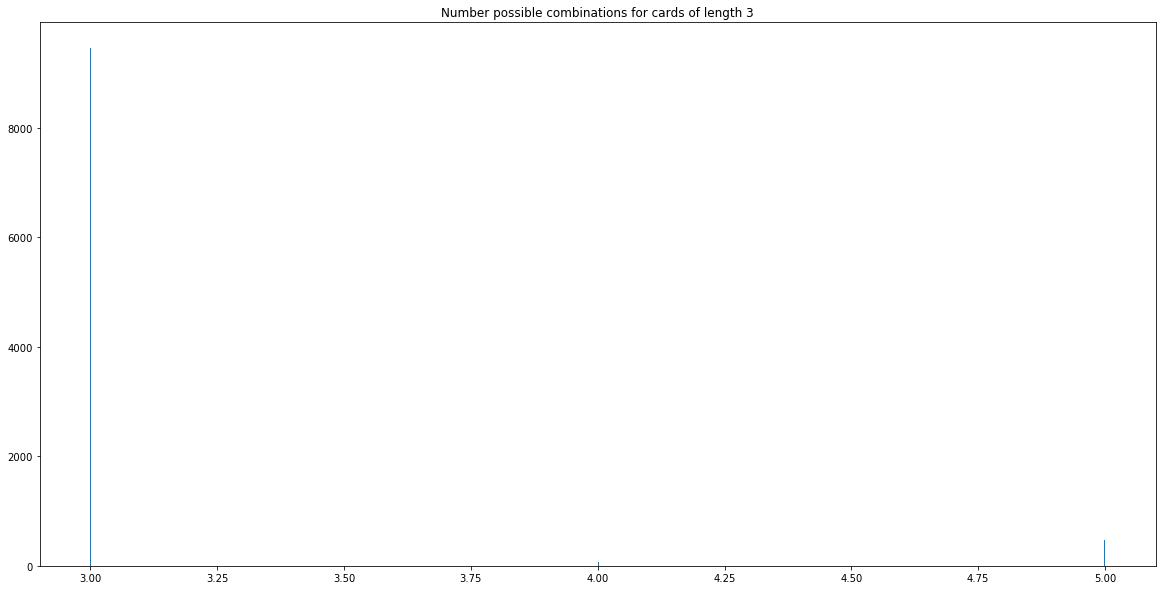

In [68]:
nbr_possible_combinations(len_=3)

220

# Lambda

In [ ]:
class A(object):
    def __init__(self):
        self.elem = 'a'

class B(object):
    def __init__(self):
        self.elem = 'b'

In [ ]:
a = A()
b = B()
l = lambda _: (a.elem, b.elem) 
a = A()
a.elem='a2'
print(l('')) # i want ('a', 'b') not ('a2', 'b')

In [ ]:
a = A()
a_ = a
b = B()
l = lambda _: (a_.elem, b.elem)
a = A()
a.elem='a2'
print(l(''))# i want ('a', 'b') not ('a2', 'b')

# Class hierarchy

In [ ]:
import inspect

class A(object):
    pass

class B(object):
    pass

class C(A, B):
    
    def bases(self):
        return self.__class__.__bases__


class D(A):
    pass

class E(D, B):
    pass

class F(C):
    pass
        


In [ ]:
A.__bases__

In [ ]:
C.__bases__

In [ ]:
D.__bases__

In [ ]:
E.__bases__

In [ ]:
e = E()
e.__class__.__bases__


In [ ]:
c = C()
c.bases()

In [ ]:
f = F()
f.bases()

In [ ]:
inspect.getmro(f.__class__)

# Tuple vs List

In [ ]:
X = 10000

In [ ]:
%%timeit
list(range(X))

In [ ]:
%%timeit
tuple(range(X))

# For..if vs filter

In [ ]:
X = 100000
def forif():  # Is Faster
    for e in range(X):
        if e < 1000:
            pass

def forfilter():
    def st(elem):
        return elem < 1000
    for e in filter(st, range(X)):
        pass


In [ ]:
%%timeit
forif()

In [ ]:
%%timeit
forfilter()

# list of gen vs list appending

In [ ]:
X = 100000
def gen():  # seems to be slightly faster (7.11ms vs 9.43ms)
    def g():
        for e in range(X):
            yield e
    return list(g())

def list_():
    l = list()
    for e in range(X):
        l.append(e)
    return l

In [ ]:
%%timeit
gen()

In [ ]:
%%timeit
list_()

# Set removeall

In [ ]:
to_remove = list(range(100))

In [ ]:
%%timeit
# remove all by iteration and .remove()
s = set(range(100000))
for e in to_remove:
    s.remove(e)

In [ ]:
%%timeit
# remove all by iter (a list)
s = set(range(100000))
s = set(e for e in s if e not in to_remove)

In [ ]:
%%timeit
# remove all by iter (a set)
s = set(range(100000))
to_remove_set = set(to_remove)
s = set(e for e in s if e not in to_remove_set)

# mutable & immutable classes

In [ ]:
from collections import namedtuple
import abc

In [ ]:
class Base(object, metaclass=abc.ABCMeta):
    
    __slots__ = ()
    
    def __new__(cls, *args, **kwargs):
        print("new Base")
        return super().__new__(cls)
    
    def __init__(self, a, b, c=None):
        print("init Base")
    
    @property
    @abc.abstractmethod
    def a(self):
        print("Base a")
        raise NotImplementedError()
    
    @property
    @abc.abstractmethod
    def b(self):
        print("Base b")
        raise NotImplementedError()
    
    @property
    @abc.abstractmethod
    def c(self):
        print("Base c")
        raise NotImplementedError()
        
    def pr_a(self):
        print("my a:", self.a)

NT = namedtuple("NT", ["a", "b"])
class Imm(NT, Base):
    __slots__ = ()
    
    def __new__(cls, *args, c="ImmC", **kwargs):
        print("new Imm")
        return super().__new__(cls, *args, **kwargs)
    
    def __init__(self, a, b, c=None):
        print("init Imm")
        super().__init__(a, b, c)

In [ ]:
class Mut(Base):
    __slots__ = ('_a', '_b', '_c')
    
    def __new__(cls, *args, **kwargs):
        print("new Mut")
        return super().__new__(cls, *args, **kwargs)
    
    def __init__(self, a, b, c=None):
        print("init Mut")
        self._a = a
        self._b = b
        self._c = c
        super().__init__(a, b, c)
        
    @property
    def a(self):
        print("Mut a")
        return self._a
    
    @a.setter
    def a(self, newa):
        print("Mut a setter")
        self._a = newa
    
    @property
    def b(self):
        print("Mut b")
        return self._b
    
    @property
    def c(self):
        print("Mut c")
        return self._c

In [ ]:
I = Imm(a=1, b=2)
M = Mut(4, 5)
nt = NT(6, 7)

In [ ]:
print(*I)

In [ ]:
I.a

In [ ]:
nt.a = 5

In [ ]:
I.a = 4

In [ ]:
M.a = 3

In [ ]:
M.a

In [ ]:
I.pr_a()

In [ ]:
M.pr_a()

# Determinization Tests

In [ ]:
from gym_tichu.envs.internals import Deck, CardSet, InitialState, GeneralCombination, all_general_combinations_gen
from gym_agents.mcts import determinization_with_prior_weights

In [ ]:
deck = Deck(full=True)
piles = deck.split(random_=True)
big_pile = CardSet(piles[1] + piles[2] + piles[3])
print(str(big_pile))

In [ ]:
posscombs = list(big_pile.possible_combinations())


In [ ]:
state = InitialState().announce_grand_tichus([]).announce_tichus([]).trade_cards(trades=list())

In [ ]:
def make_random_weights_dict():  #  Dict[GeneralCombination, Dict[Len, float]]
    d = dict()
    for gcomb in all_general_combinations_gen():
        weights = [random.random() for _ in range(1, 15)]
        s = sum(weights)
        weights = [w / s for w in weights]
        d[gcomb] = {l+1: w for l, w in enumerate(weights)}
    return d

weights_dict = make_random_weights_dict()

In [ ]:
def make_len_to_gcomb_to_proba_dict(weights_dict):  #  Dict[Len, Dict[GeneralCombination, float]]
    d = {l: {gcomb: 0.0 for gcomb in all_general_combinations_gen()} for l in range(1, 15)}
    for gcomb, len_proba in weights_dict.items():
        for l, proba in len_proba.items():
            d[l][gcomb] = proba
    return d
len_to_gcomb_to_proba_dict = make_len_to_gcomb_to_proba_dict(weights_dict)

In [ ]:
cards = CardSet(piles[1] + piles[2])
goal_lengths = (11, 8, 9)
assert len(cards) == sum(goal_lengths)
handcards = {1:list(), 2:list(), 3:list()}
posscombs = list(cards.possible_combinations())
possgcombs = [GeneralCombination.from_combination(comb) for comb in posscombs]

In [ ]:
def combweights_for_length(length):
    return {comb: len_to_gcomb_to_proba_dict[length][gcomb] 
                    for comb, gcomb in zip(posscombs, possgcombs)}

combweights_left = combweights_for_length(goal_lengths[0])
combweights_tm = combweights_for_length(goal_lengths[1])
combweights_right = combweights_for_length(goal_lengths[2])

In [ ]:
sum([0.07194244604316546,
0.12765273311897107,
0.10952460944061818,
0.08176809416478838,
0.059881227317716924,
0.05004688232536334,
0.04884117403123992,
0.0480146224631287,
0.03621113618755684,
0.03073969936195523,
0.02901127318275486,
0.02829725751049561,
0.02800301431801055,
0.027585375709839564])

In [ ]:
det = determinization_with_prior_weights(state, 0, make_random_weights_dict())
print(det)

In [ ]:
raise StopIteration("stop")

# Some Timing and otherexperiments

In [ ]:
def outer():
    print("outer")

class A(object):
    
    def __init__(self):
        self.myouter = outer
    
    def a():
        print("A.a")
    

In [ ]:
a = A()
a.myouter()

In [ ]:
s = set(range(10))
l = list(s)
n = 1000

In [ ]:
%%timeit
for _ in range(n):
    gen = iter(s)
    for _ in range(random.randrange(0, len(s))):
        next(gen)
    next(gen)

In [ ]:
%%timeit
for _ in range(n):
    next(iter(s))

In [ ]:
%%timeit
for _ in range(n):
    next(itertools.islice(s, random.randrange(0, len(s)), None))

In [ ]:
%%timeit
for _ in range(n):
    random.choice(list(s))

In [ ]:
%%timeit
for _ in range(n):
    random.choice(l)

In [ ]:
s = set(range(1000))
l = list(s)

In [ ]:
%%timeit
for _ in range(n):
    s = set(range(1000))
    set(l)

In [ ]:
%%timeit
for _ in range(n):
    l = list(range(1000))
    list(s)

In [ ]:
import gym
import importlib
import gym_tichu.envs.internals as new
from gym_tichu.envs.internals import CardSet
import game.tichu.cards as old
from game.tichu.cards import ImmutableCards
import random
import itertools

In [ ]:

def old_card_from_new(newc):
    n = newc.name
    oldc = next(c for c in old.Card if c.name == n)
    return oldc

def create_new_piles(phoenix=False):
    deck_new = new.Deck(full=True)
    _new = deck_new.split(random_=True)[0][:10]
    _old = [old_card_from_new(c) for c in _new]
    if phoenix and new.Card.PHOENIX not in _new:
        _new.append(new.Card.PHOENIX)
    if phoenix and old.Card.PHOENIX not in _old:
        _old.append(old.Card.PHOENIX)
    return sorted(_new), sorted(_old)


# Comparison Old vs New Possible Combinations of cards

In [ ]:
def filter_duplicates(combs):
    d = dict()
    filtered = list()
    for comb in combs:
        try:
            t = (comb.__class__, len(comb), comb.height, tuple([c.value[0] for c in comb]), comb.phoenix_as)
        except AttributeError:
            t = (comb.__class__, len(comb), tuple([c.value[0] for c in comb]), comb.height)
        if t in d:
            filtered.append(d[t])
        d[t] = comb
    return list(d.values()), filtered

def compare_length():
    #print("compare len:")
    #print("create new piles...")
    pn, po = create_new_piles(phoenix=True)
    #print("pile: ", pn)
    #print("create cards...")
    old_cards = ImmutableCards(po)
    new_cards = CardSet(pn)
    #print("create combiantions...")
    combs_old, filtered_old = filter_duplicates(list(old_cards.all_combinations()))
    combs_new, filtered_new = filter_duplicates(list(new_cards.possible_combinations()))
    #print("...done")
    return len(combs_old), len(combs_new), old_cards, new_cards, filtered_old, filtered_new


    

In [ ]:
lo = 0
ln = 0
tries = 1
while lo == ln:
    lo, ln, old_cards, new_cards, filtered_old, filtered_new = compare_length()
    #print("filtered_old:", '\n'.join(map(str, filtered_old)))
    #print("\nfiltered_new:", '\n'.join(map(str, filtered_new)))
    tries += 1

print('tries:', tries)
print(lo, ln)
print()
print("____________________")
print(old_cards)
print(sorted(new_cards))
print("-----------Old: ----------")
for combo in old_cards.all_combinations():
    print(combo)
print()
print("-----------New: ----------")
for combn in new_cards.possible_combinations():
    print(combn) 

In [ ]:
l = list(range(14))

In [ ]:
%%timeit
[str(i) for i in range(14)]

In [ ]:
%%timeit
list(map(str, range(14)))